In [0]:
# installs
!pip install PyDrive

In [0]:
# imports
import os
import sys
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import random
from shutil import copyfile

In [0]:
# Google drive Auth
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# download data

download_cartoon = drive.CreateFile({'id': '1lg00HDOwtgstdypuJp3yQxT81klaS6-i'})
download_cartoon.GetContentFile('cartoon.zip')

download_caricature = drive.CreateFile({'id': '1VbHnWtYu5tCrQwfeiuWd2Pkf_5Sq-ahn'})
download_caricature.GetContentFile('caricature.zip')

In [0]:
# unzip
!mkdir cartoon
!mkdir caricature

!unzip cartoon.zip -d cartoon
!unzip caricature.zip -d caricature

In [0]:
# deep learning imports
from keras.models import Model
from keras.layers import Flatten, GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam, SGD

In [0]:
# helper defs
import math
from keras.preprocessing import image

def plot_results(images_with_prediction, cols = 5):
    rows = math.ceil(len(images_with_prediction) / cols)
    fig = plt.figure(figsize=(22,12))
    k = 1

    for key in images_with_prediction:
      img = image.load_img(key, target_size=(224, 224))
      ax = fig.add_subplot(rows, cols, k)
      ax.imshow(img)
      ax.set_title(images_with_prediction[key])
      ax.axis('off')
      k += 1

    plt.show()
          
def load_image(filename, show=False):
    img = image.load_img(filename, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255. 

    return img_tensor
 
def summarize_diagnostics(history):	
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # save plot to file
  filename = sys.argv[0].split('/')[-1]
  plt.savefig(filename + '_plot.png')
  plt.close()

In [0]:
# creating train/test dirs and savings images

# create directories
dataset_home = 'dataset/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	dirs = ['cartoon/', 'caricature/']
	for dr in dirs:
		newdir = dataset_home + subdir + dr
		os.makedirs(newdir, exist_ok=True)
  
random.seed(42)
# define ratio of pictures to use for validation
val_ratio = 0.30
# copy training dataset images into subdirectories
src_dirs = ['cartoon/', 'caricature/']

for src_dir in src_dirs:
  for file in os.listdir(src_dir):
    src = src_dir + '/' + file
    dst_dir = 'train/'
    if random.random() < val_ratio:
      dst_dir = 'test/'
    dst = dataset_home + dst_dir + src_dir + '/'  + file
    copyfile(src, dst)

In [0]:
# data augumentation
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

batch_size = 16
img_dim = (224, 224)

train_datagen = ImageDataGenerator(
        rotation_range=40,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        dataset_home + subdirs[0],  # this is the target directory
        target_size = img_dim, 
        batch_size = batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

test_generator = test_datagen.flow_from_directory(
        dataset_home + subdirs[1],  # this is the target directory
        target_size = img_dim,
        batch_size = batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

In [0]:
# define model

texture_layer = 'block1_conv2'

base_model = VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
for layer in base_model.layers:
  layer.trainable = False
  
flat = GlobalAveragePooling2D()(base_model.get_layer(texture_layer).output)
dense1 = Dense(256, activation = 'relu', kernel_initializer = 'he_uniform')(flat)
norm1 = Dropout(0.5)(dense1)
output = Dense(1, activation = 'sigmoid')(norm1)

model = Model(inputs=base_model.input, outputs = output)
optimizer = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


In [0]:
# train model
history = model.fit_generator(
        train_generator,
        steps_per_epoch=4000 // batch_size,
        epochs=40,
        validation_data=test_generator,
        validation_steps=1200 // batch_size)
model.save('model.h5')

In [0]:
# evaluate model
_, acc = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=0)
print('> %.3f' % (acc * 100.0))

summarize_diagnostics(history)

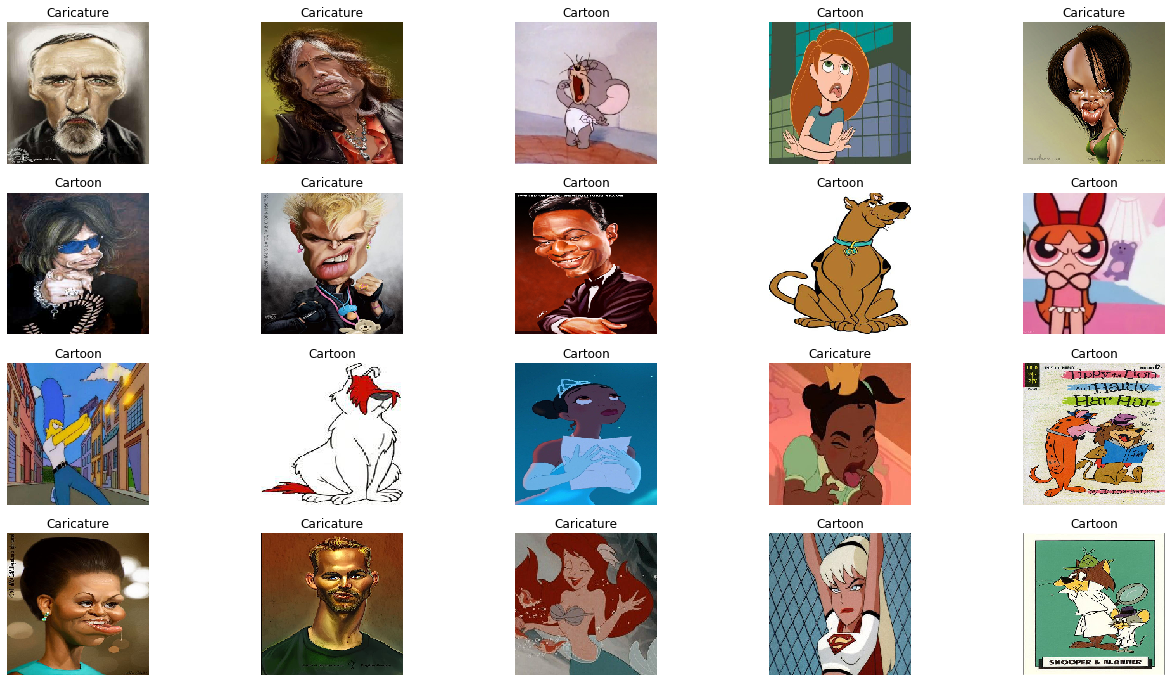

In [6]:
# make predictions
from keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

labels = ['Caricature', 'Cartoon']
threshold = 0.2

# load model
model = load_model('model.h5')

predict_images = []
predict_images.append('1.jpg')
predict_images.append('2.jpg')
predict_images.append('3.png')
predict_images.append('4.jpg')
predict_images.append('5.png')
predict_images.append('6.png')
predict_images.append('7.png')
predict_images.append('8.png')
predict_images.append('9.jpg')
predict_images.append('10.jpg')
predict_images.append('11.jpg')
predict_images.append('12.jpg')
predict_images.append('13.jpg')
predict_images.append('14.jpg')
predict_images.append('15.jpg')
predict_images.append('16.jpg')
predict_images.append('17.jpg')
predict_images.append('18.jpg')
predict_images.append('19.jpg')
predict_images.append('20.jpg')

images_with_prediction = {}

for img_name in predict_images:
  if model.predict(load_image(img_name))[0][0] < threshold:
    images_with_prediction[img_name] = 'Caricature'
  else:
    images_with_prediction[img_name] = 'Cartoon'

plot_results(images_with_prediction)